In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Đọc dữ liệu
data = pd.read_csv('../datas/train_div10.csv')
data_test = pd.read_csv('../datas/test_div10.csv')

In [21]:
import pandas as pd
import numpy as np

def create_training_data(data, window_size=20, step_size=10):
    """
    Chia dữ liệu cảm biến thành các cửa sổ trượt (sliding windows) 
    và tạo nhãn cho mỗi cửa sổ.
    """
    x_list, y_list, z_list, train_labels = [], [], [], []

    for i in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[i : i + window_size]

        # Bỏ qua nếu nhãn trong cửa sổ thay đổi
        if window['activity'].nunique() > 1:
            continue

        label = window['activity'].iloc[0]
        if pd.isna(label):
            continue

        x_list.append(window['x'].values)
        y_list.append(window['y'].values)
        z_list.append(window['z'].values)
        train_labels.append(label)

    return x_list, y_list, z_list, train_labels


In [22]:
x_list, y_list, z_list, train_labels = create_training_data(data)
  

Số cửa sổ hợp lệ: 15674
Kích thước 1 cửa sổ mẫu: 20
Ví dụ 1 cửa sổ đầu tiên - nhãn: 1


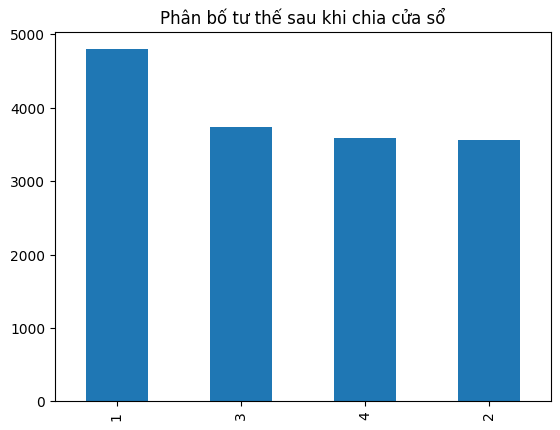

In [23]:
# Tổng số cửa sổ hợp lệ
print("Số cửa sổ hợp lệ:", len(train_labels))

# Phân bố nhãn
pd.Series(train_labels).value_counts().plot(kind='bar', title='Phân bố tư thế sau khi chia cửa sổ')

# Kiểm tra hình dạng
print("Kích thước 1 cửa sổ mẫu:", len(x_list[0]))
print("Ví dụ 1 cửa sổ đầu tiên - nhãn:", train_labels[0])


In [24]:
features = []
for i in range(len(x_list)):
    fx = np.mean(x_list[i])
    fy = np.mean(y_list[i])
    fz = np.mean(z_list[i])
    features.append([fx, fy, fz])
features_df = pd.DataFrame(features, columns=['x_mean','y_mean','z_mean'])
features_df['label'] = train_labels


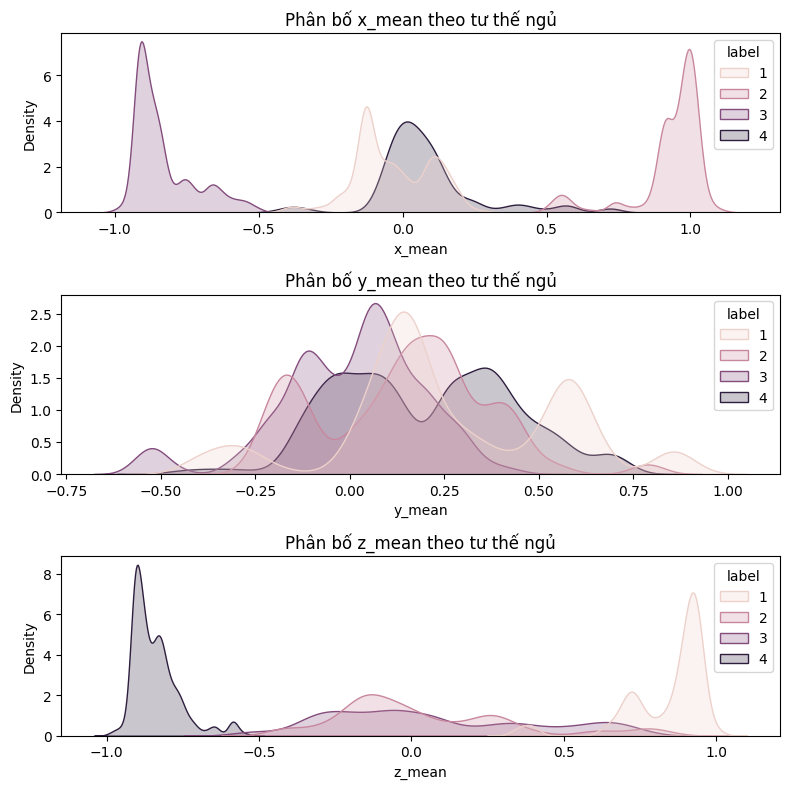

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8))

axes_list = ['x_mean', 'y_mean', 'z_mean']

for i, axis in enumerate(axes_list):
    sns.kdeplot(data=features_df, x=axis, hue='label', fill=True, common_norm=False, ax=axes[i])
    axes[i].set_title(f'Phân bố {axis} theo tư thế ngủ')

plt.tight_layout()
plt.show()


In [26]:
from scipy.signal import find_peaks
from scipy import stats
import numpy as np
import pandas as pd

def calculate_accelerometer_features(x_list, y_list, z_list, window_size=20):
    X_train = pd.DataFrame()

    # mean
    X_train['x_mean'] = [np.mean(x) for x in x_list]
    X_train['y_mean'] = [np.mean(y) for y in y_list]
    X_train['z_mean'] = [np.mean(z) for z in z_list]

    # std dev
    X_train['x_std'] = [np.std(x) for x in x_list]
    X_train['y_std'] = [np.std(y) for y in y_list]
    X_train['z_std'] = [np.std(z) for z in z_list]

    # average absolute deviation
    X_train['x_aad'] = [np.mean(np.abs(x - np.mean(x))) for x in x_list]
    X_train['y_aad'] = [np.mean(np.abs(y - np.mean(y))) for y in y_list]
    X_train['z_aad'] = [np.mean(np.abs(z - np.mean(z))) for z in z_list]

    # min / max
    X_train['x_min'] = [np.min(x) for x in x_list]
    X_train['y_min'] = [np.min(y) for y in y_list]
    X_train['z_min'] = [np.min(z) for z in z_list]

    X_train['x_max'] = [np.max(x) for x in x_list]
    X_train['y_max'] = [np.max(y) for y in y_list]
    X_train['z_max'] = [np.max(z) for z in z_list]

    # max-min difference
    X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
    X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
    X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

    # median / MAD
    X_train['x_median'] = [np.median(x) for x in x_list]
    X_train['y_median'] = [np.median(y) for y in y_list]
    X_train['z_median'] = [np.median(z) for z in z_list]

    X_train['x_mad'] = [np.median(np.abs(x - np.median(x))) for x in x_list]
    X_train['y_mad'] = [np.median(np.abs(y - np.median(y))) for y in y_list]
    X_train['z_mad'] = [np.median(np.abs(z - np.median(z))) for z in z_list]

    # IQR
    X_train['x_IQR'] = [np.percentile(x, 75) - np.percentile(x, 25) for x in x_list]
    X_train['y_IQR'] = [np.percentile(y, 75) - np.percentile(y, 25) for y in y_list]
    X_train['z_IQR'] = [np.percentile(z, 75) - np.percentile(z, 25) for z in z_list]

    # negative / positive counts
    X_train['x_neg_count'] = [np.sum(x < 0) for x in x_list]
    X_train['y_neg_count'] = [np.sum(y < 0) for y in y_list]
    X_train['z_neg_count'] = [np.sum(z < 0) for z in z_list]

    X_train['x_pos_count'] = [np.sum(x > 0) for x in x_list]
    X_train['y_pos_count'] = [np.sum(y > 0) for y in y_list]
    X_train['z_pos_count'] = [np.sum(z > 0) for z in z_list]

    # values above mean
    X_train['x_above_mean'] = [np.sum(x > np.mean(x)) for x in x_list]
    X_train['y_above_mean'] = [np.sum(y > np.mean(y)) for y in y_list]
    X_train['z_above_mean'] = [np.sum(z > np.mean(z)) for z in z_list]

    # number of peaks
    X_train['x_peak_count'] = [len(find_peaks(x)[0]) for x in x_list]
    X_train['y_peak_count'] = [len(find_peaks(y)[0]) for y in y_list]
    X_train['z_peak_count'] = [len(find_peaks(z)[0]) for z in z_list]

    # skewness / kurtosis
    X_train['x_skewness'] = [stats.skew(x) for x in x_list]
    X_train['y_skewness'] = [stats.skew(y) for y in y_list]
    X_train['z_skewness'] = [stats.skew(z) for z in z_list]

    X_train['x_kurtosis'] = [stats.kurtosis(x) for x in x_list]
    X_train['y_kurtosis'] = [stats.kurtosis(y) for y in y_list]
    X_train['z_kurtosis'] = [stats.kurtosis(z) for z in z_list]

    # energy
    X_train['x_energy'] = [np.sum(x**2) / window_size for x in x_list]
    X_train['y_energy'] = [np.sum(y**2) / window_size for y in y_list]
    X_train['z_energy'] = [np.sum(z**2) / window_size for z in z_list]

    # average resultant acceleration
    X_train['avg_result_accl'] = [np.mean(np.sqrt(x**2 + y**2 + z**2)) for x, y, z in zip(x_list, y_list, z_list)]

    # signal magnitude area (SMA)
    X_train['sma'] = [(np.sum(np.abs(x)) + np.sum(np.abs(y)) + np.sum(np.abs(z))) / window_size
                      for x, y, z in zip(x_list, y_list, z_list)]

    return X_train


In [27]:
X_train = calculate_accelerometer_features(x_list, y_list, z_list)
X_train['label'] = train_labels  # thêm nhãn vào


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20204\1479724499.py:72: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  X_train['x_skewness'] = [stats.skew(x) for x in x_list]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20204\1479724499.py:73: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  X_train['y_skewness'] = [stats.skew(y) for y in y_list]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20204\1479724499.py:74: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  X_train['z_skewness'] = [stats.skew(z) for z in z_list]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20204\1479724499.py:76: RuntimeWarning: Precision loss occurred i

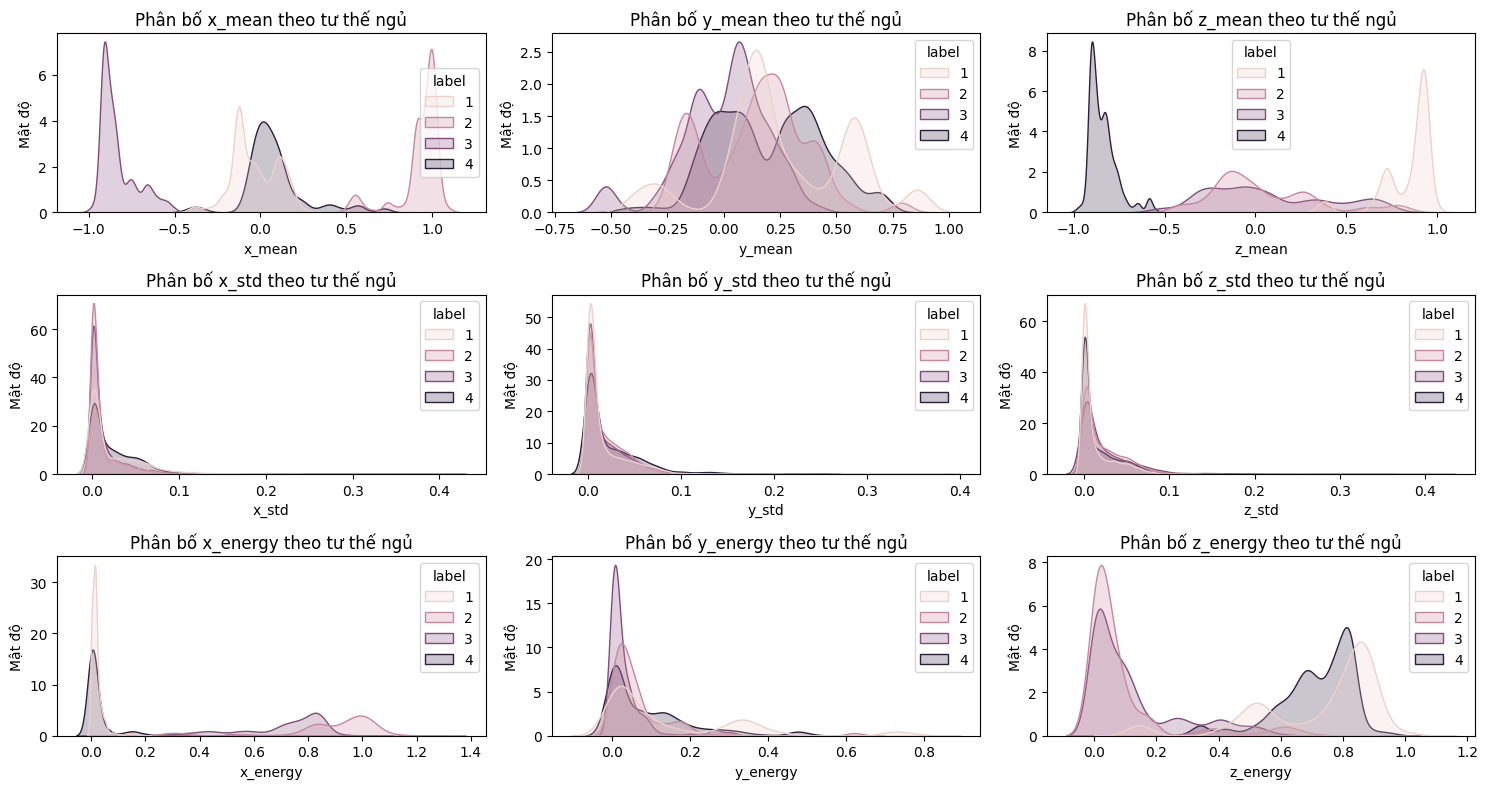

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = ['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std',"x_energy","y_energy","z_energy"]

fig, axes = plt.subplots(3, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.kdeplot(data=X_train, x=feature, hue='label', fill=True, common_norm=False, ax=axes[i])
    axes[i].set_title(f'Phân bố {feature} theo tư thế ngủ')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Mật độ')

plt.tight_layout()
plt.show()


In [32]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy import stats

def calculate_accelerometer_fft_features(x_list, y_list, z_list, window_size=20, keep_dc=False):
    """
    Tính các đặc trưng miền tần số từ các cửa sổ x_list/y_list/z_list.
    - Sử dụng rfft để lấy n_freq = window_size//2 + 1 hệ số (với tín hiệu thực).
    - Mặc định loại bỏ thành phần DC (keep_dc=False). Nếu muốn giữ DC, set keep_dc=True.
    Trả về DataFrame features_fft.
    """
    nfft = window_size
    # số hệ số rfft (bao gồm DC)
    n_bins = nfft // 2 + 1

    # Tính phổ (magnitude) cho mỗi cửa sổ, dùng rfft (trả về n_bins). 
    # Loại bỏ DC nếu keep_dc=False (bắt đầu từ idx 1)
    x_fft_list = [np.abs(np.fft.rfft(x, n=nfft)) for x in x_list]
    y_fft_list = [np.abs(np.fft.rfft(y, n=nfft)) for y in y_list]
    z_fft_list = [np.abs(np.fft.rfft(z, n=nfft)) for z in z_list]

    if not keep_dc:
        # bỏ phần tử thứ 0 (DC)
        x_fft_list = [arr[1:] for arr in x_fft_list]  # length n_bins-1
        y_fft_list = [arr[1:] for arr in y_fft_list]
        z_fft_list = [arr[1:] for arr in z_fft_list]
        nb = n_bins - 1
    else:
        nb = n_bins

    # Bắt đầu tính đặc trưng bằng list comprehension (theo từng cửa sổ)
    features = {
        'x_mean_fft':    [arr.mean() for arr in x_fft_list],
        'y_mean_fft':    [arr.mean() for arr in y_fft_list],
        'z_mean_fft':    [arr.mean() for arr in z_fft_list],

        'x_std_fft':     [arr.std(ddof=0) for arr in x_fft_list],
        'y_std_fft':     [arr.std(ddof=0) for arr in y_fft_list],
        'z_std_fft':     [arr.std(ddof=0) for arr in z_fft_list],

        'x_aad_fft':     [np.mean(np.abs(arr - arr.mean())) for arr in x_fft_list],
        'y_aad_fft':     [np.mean(np.abs(arr - arr.mean())) for arr in y_fft_list],
        'z_aad_fft':     [np.mean(np.abs(arr - arr.mean())) for arr in z_fft_list],

        'x_min_fft':     [arr.min() for arr in x_fft_list],
        'y_min_fft':     [arr.min() for arr in y_fft_list],
        'z_min_fft':     [arr.min() for arr in z_fft_list],

        'x_max_fft':     [arr.max() for arr in x_fft_list],
        'y_max_fft':     [arr.max() for arr in y_fft_list],
        'z_max_fft':     [arr.max() for arr in z_fft_list],

        'x_median_fft':  [np.median(arr) for arr in x_fft_list],
        'y_median_fft':  [np.median(arr) for arr in y_fft_list],
        'z_median_fft':  [np.median(arr) for arr in z_fft_list],

        'x_mad_fft':     [np.median(np.abs(arr - np.median(arr))) for arr in x_fft_list],
        'y_mad_fft':     [np.median(np.abs(arr - np.median(arr))) for arr in y_fft_list],
        'z_mad_fft':     [np.median(np.abs(arr - np.median(arr))) for arr in z_fft_list],

        'x_IQR_fft':     [np.percentile(arr, 75) - np.percentile(arr, 25) for arr in x_fft_list],
        'y_IQR_fft':     [np.percentile(arr, 75) - np.percentile(arr, 25) for arr in y_fft_list],
        'z_IQR_fft':     [np.percentile(arr, 75) - np.percentile(arr, 25) for arr in z_fft_list],

        'x_above_mean_fft': [np.sum(arr > arr.mean()) for arr in x_fft_list],
        'y_above_mean_fft': [np.sum(arr > arr.mean()) for arr in y_fft_list],
        'z_above_mean_fft': [np.sum(arr > arr.mean()) for arr in z_fft_list],

        'x_peak_count_fft': [len(find_peaks(arr)[0]) for arr in x_fft_list],
        'y_peak_count_fft': [len(find_peaks(arr)[0]) for arr in y_fft_list],
        'z_peak_count_fft': [len(find_peaks(arr)[0]) for arr in z_fft_list],

        'x_skewness_fft': [stats.skew(arr) for arr in x_fft_list],
        'y_skewness_fft': [stats.skew(arr) for arr in y_fft_list],
        'z_skewness_fft': [stats.skew(arr) for arr in z_fft_list],

        'x_kurtosis_fft': [stats.kurtosis(arr) for arr in x_fft_list],
        'y_kurtosis_fft': [stats.kurtosis(arr) for arr in y_fft_list],
        'z_kurtosis_fft': [stats.kurtosis(arr) for arr in z_fft_list],
    }

    # energy: tổng bình phương magnitude chia cho số bins (nb)
    features['x_energy_fft'] = [np.sum(arr**2) / float(nb) for arr in x_fft_list]
    features['y_energy_fft'] = [np.sum(arr**2) / float(nb) for arr in y_fft_list]
    features['z_energy_fft'] = [np.sum(arr**2) / float(nb) for arr in z_fft_list]

    # avg resultant in freq domain: mean of sqrt(x^2 + y^2 + z^2) across frequency bins
    features['avg_result_accl_fft'] = [
        np.mean(np.sqrt(xf**2 + yf**2 + zf**2))
        for xf, yf, zf in zip(x_fft_list, y_fft_list, z_fft_list)
    ]

    # sma_fft: sum of absolute magnitudes across 3 axes divided by nb
    features['sma_fft'] = [
        (np.sum(np.abs(xf)) + np.sum(np.abs(yf)) + np.sum(np.abs(zf))) / float(nb)
        for xf, yf, zf in zip(x_fft_list, y_fft_list, z_fft_list)
    ]

    features_fft = pd.DataFrame(features)
    # thêm cột số bins để dễ kiểm tra/debug nếu cần
    features_fft['n_fft_bins'] = nb

    return features_fft


In [33]:
features_fft = calculate_accelerometer_fft_features(x_list, y_list, z_list, window_size=20)
features_fft['label'] = train_labels

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20204\350896183.py:74: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'x_skewness_fft': [stats.skew(arr) for arr in x_fft_list],
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20204\350896183.py:75: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'y_skewness_fft': [stats.skew(arr) for arr in y_fft_list],
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20204\350896183.py:78: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'x_kurtosis_fft': [stats.kurtosis(arr) for arr in x_fft_list],
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20204\350896183.py:79: RuntimeWarning: Precision loss o

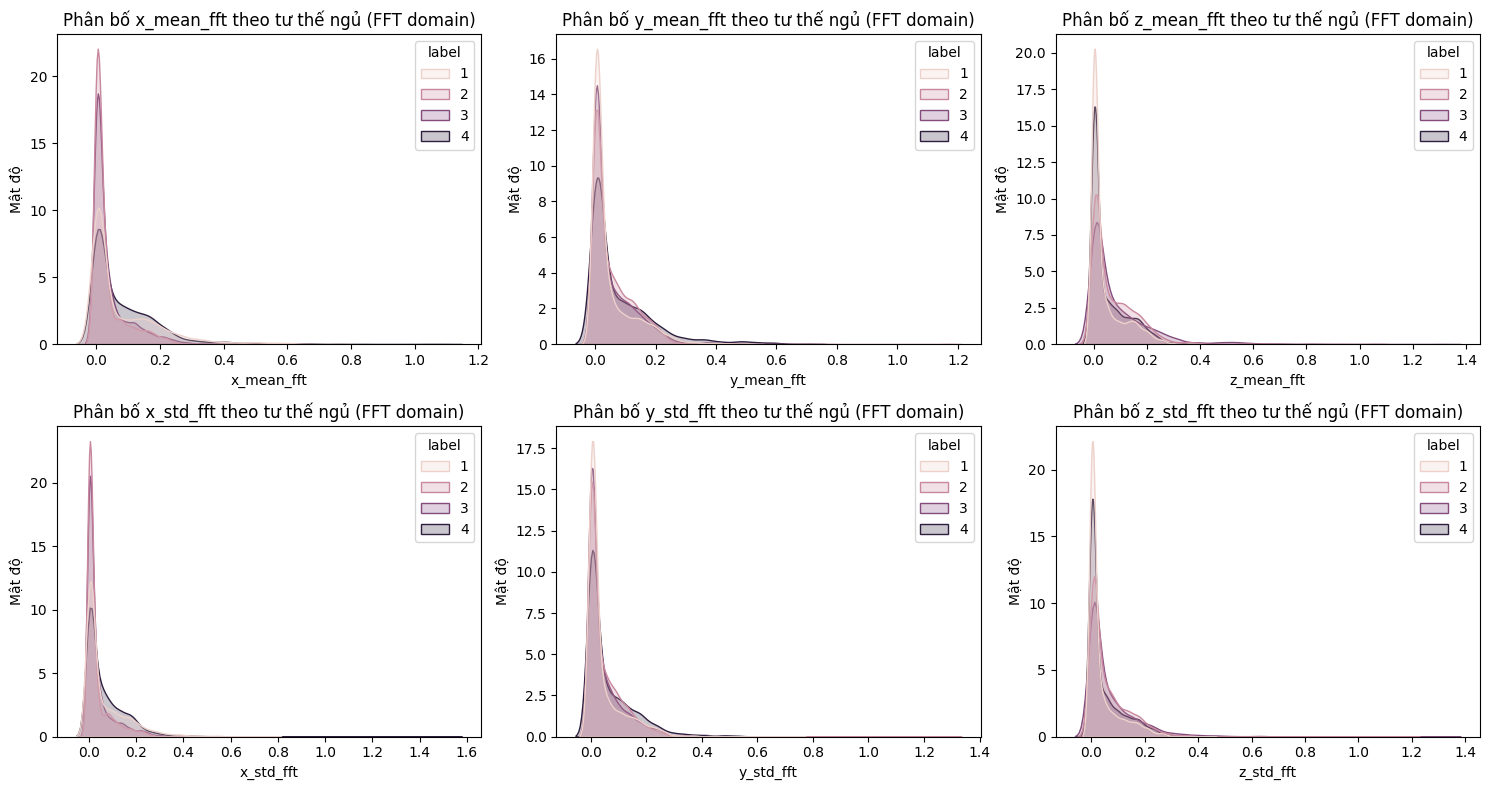

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot_fft = ['x_mean_fft', 'y_mean_fft', 'z_mean_fft', 'x_std_fft', 'y_std_fft', 'z_std_fft']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot_fft):
    sns.kdeplot(data=features_fft, x=feature, hue='label', fill=True, common_norm=False, ax=axes[i])
    axes[i].set_title(f'Phân bố {feature} theo tư thế ngủ (FFT domain)')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Mật độ')

plt.tight_layout()
plt.show()
